# Reading Processed Data

In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

train_df.head()

,label,text
0,0,chris quick question is this the pcifs that pe...
1,1,welcome to health suite chek it out gra vicodi...
2,0,from the desk of chuck wilkinson i am pleased ...
3,0,good afternoon fred after our call a better so...
4,1,you registered to receive this and similar off...


In [5]:
X_train = train_df['text']
X_test = test_df['text']
y_train = train_df['label']
y_test = test_df['label']

# Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',  # Remove common English words
    max_features=50000,
    ngram_range=(1, 2)  # Use single words and word pairs
)

# Convert text to numerical features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")

Training shape: (63152, 50000)
Test shape: (15788, 50000)


# Model Training

In [7]:
from sklearn.svm import SVC, LinearSVC
import time

# Create SVM model (LinearSVC works better for text)
model = LinearSVC(C=1.0, max_iter=1000, random_state=42)

# Train the model
print("Training SVM model...")
start_time = time.time()
model.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

Training SVM model...
Training completed in 2.43 seconds


## Model Evaluation

In [8]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Accuracy: 0.9899

Confusion Matrix:
[[7551  106]
 [  54 8077]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      7657
        Spam       0.99      0.99      0.99      8131

    accuracy                           0.99     15788
   macro avg       0.99      0.99      0.99     15788
weighted avg       0.99      0.99      0.99     15788



## Visualizations

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

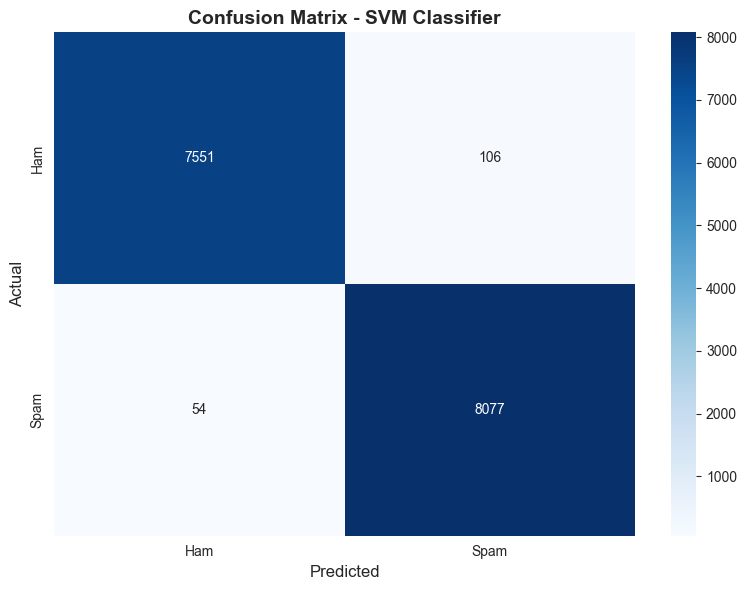

In [10]:
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - SVM Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

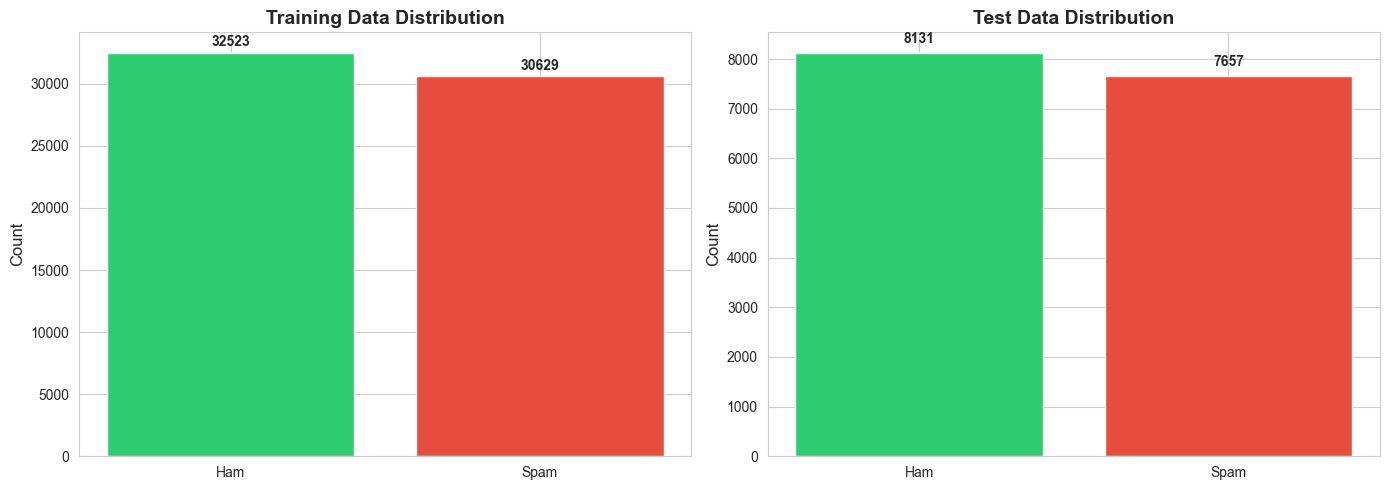

In [11]:
# 2. Class Distribution in Dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data distribution
train_counts = y_train.value_counts()
axes[0].bar(['Ham', 'Spam'], train_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Training Data Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Test data distribution
test_counts = y_test.value_counts()
axes[1].bar(['Ham', 'Spam'], test_counts.values, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Test Data Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

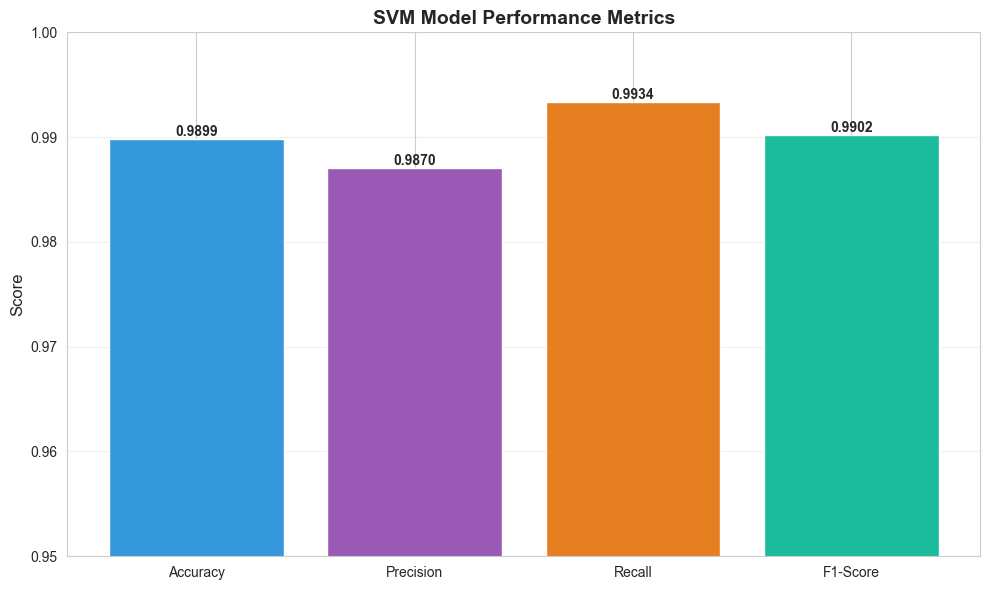

In [12]:
# 3. Performance Metrics Bar Chart
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy,
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['#3498db', '#9b59b6', '#e67e22', '#1abc9c'])
plt.ylim(0.95, 1.0)
plt.title('SVM Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

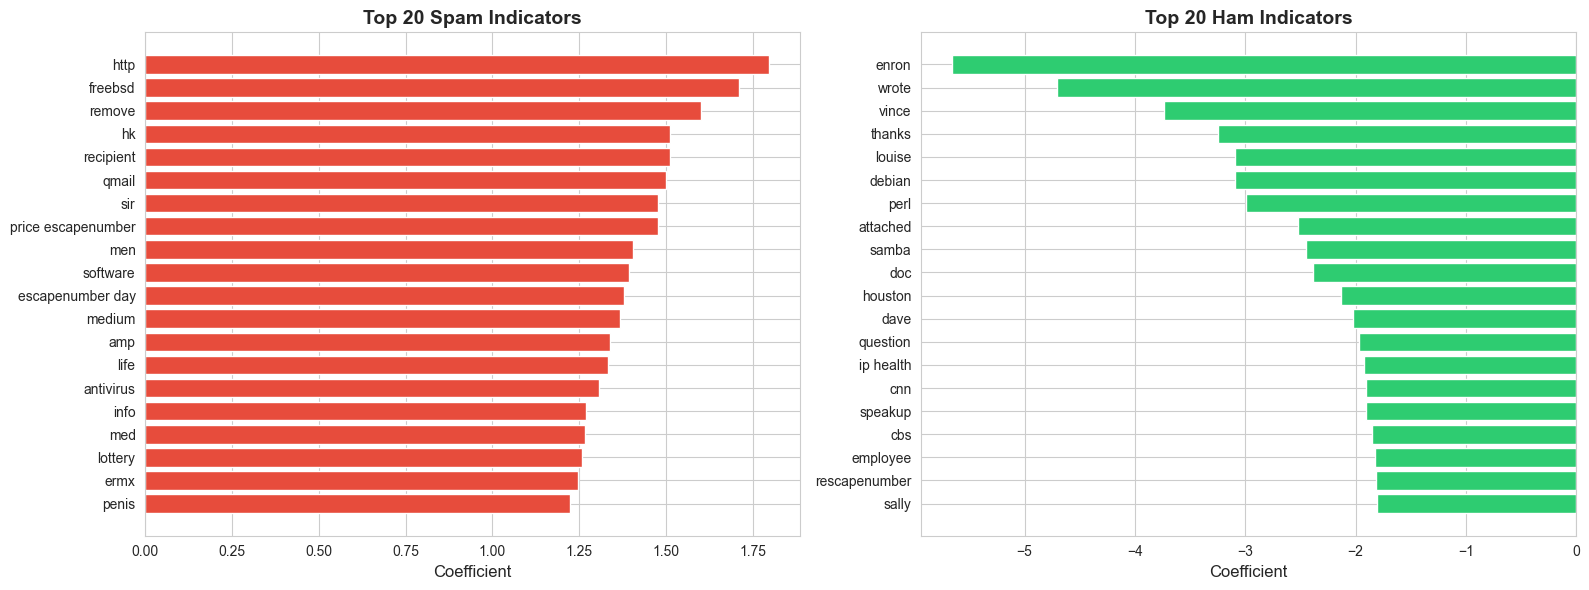

In [13]:
# 4. Top 20 Most Important Features (Words for Spam vs Ham)
# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# Top spam indicators (positive coefficients)
top_spam_indices = coefficients.argsort()[-20:][::-1]
top_spam_words = [(feature_names[i], coefficients[i]) for i in top_spam_indices]

# Top ham indicators (negative coefficients)
top_ham_indices = coefficients.argsort()[:20]
top_ham_words = [(feature_names[i], coefficients[i]) for i in top_ham_indices]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Spam words
words_spam, coefs_spam = zip(*top_spam_words)
axes[0].barh(range(len(words_spam)), coefs_spam, color='#e74c3c')
axes[0].set_yticks(range(len(words_spam)))
axes[0].set_yticklabels(words_spam)
axes[0].set_xlabel('Coefficient', fontsize=12)
axes[0].set_title('Top 20 Spam Indicators', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Ham words
words_ham, coefs_ham = zip(*top_ham_words)
axes[1].barh(range(len(words_ham)), coefs_ham, color='#2ecc71')
axes[1].set_yticks(range(len(words_ham)))
axes[1].set_yticklabels(words_ham)
axes[1].set_xlabel('Coefficient', fontsize=12)
axes[1].set_title('Top 20 Ham Indicators', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [14]:
# 5. Error Analysis - Show misclassified examples
# Get indices of misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]

print(f"Total Misclassified: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Error Rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n")

# Show a few misclassified examples
print("=" * 80)
print("Sample Misclassified Emails:")
print("=" * 80)
for i, idx in enumerate(misclassified_indices[:5]):
    actual = 'Spam' if y_test.iloc[idx] == 1 else 'Ham'
    predicted = 'Spam' if y_pred[idx] == 1 else 'Ham'
    text_preview = X_test.iloc[idx][:200] + "..."
    
    print(f"\nExample {i+1}:")
    print(f"Actual: {actual} | Predicted: {predicted}")
    print(f"Text: {text_preview}")
    print("-" * 80)

Total Misclassified: 160 out of 15788
Error Rate: 1.01%

Sample Misclassified Emails:

Example 1:
Actual: Ham | Predicted: Spam
Text: plunged the needle into ingmars eye she shuddered how dreadful themselves with their headshawls and the boy had pulled off their i have not seen any wolf said the pastor and began to tear open the env...
--------------------------------------------------------------------------------

Example 2:
Actual: Spam | Predicted: Ham
Text: hello you two i am so sorry catherine for not writing recently i have just been vv busybeing a working mother and sometimes it all get too much you know i cannot wait to see you both although we may m...
--------------------------------------------------------------------------------

Example 3:
Actual: Ham | Predicted: Spam
Text: hello in sescapenumber is listed under named assertion and is not explicitly mentioned in the section on character class can sp be used in character class in particular to include or exclude space you

## Model Saving

In [ ]:
import pickle
import os

# Create folder for models
os.makedirs('../models', exist_ok=True)

# Save the model
with open('../models/svm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the vectorizer
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully!")
print("- Model: ../models/svm_model.pkl")
print("- Vectorizer: ../models/tfidf_vectorizer.pkl")

Model and vectorizer saved successfully!
- Model: ../models/svm_model.pkl
- Vectorizer: ../models/tfidf_vectorizer.pkl
